In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
import os
from functools import lru_cache

In [2]:
def compute_r_table(template_edges):
    rows, cols = template_edges.shape
    r_table = {}
    yc = rows / 2
    xc = cols / 2
    for y in range(rows):
        for x in range(cols):
            if template_edges[y, x] > 0: 
                dx = x - xc
                dy = y - yc
                angle = math.atan2(dy, dx)
                # r = math.hypot(dx, dy) # sqrt(x*x + y*y)
                angle = math.degrees(angle) # converts an angle from radians to degrees.
                if angle not in r_table:
                    r_table[angle] = []
                r_table[angle].append([dx, dy])
    return r_table

@lru_cache(None)
def get_cos_sin_values(angle_step):
    angles_deg = np.linspace(0, 360, 360 // angle_step, endpoint=False)
    angles_rad = np.deg2rad(angles_deg)
    cos_values = np.cos(angles_rad)
    sin_values = np.sin(angles_rad)
    return cos_values, sin_values

def generalized_hough_transform(reference, template, angle_step):
    """
    實現廣義 Hough 轉換算法,檢測圖像中的目標形狀。
    """
    # 1. 邊緣檢測
    template_edges = cv2.Canny(template, 50, 150)
    r_table = compute_r_table(template_edges)

    # 2. 在參考圖像上進行邊緣檢測
    reference_edges = cv2.Canny(reference, 50, 150)
    rows, cols = reference_edges.shape

    # 3. 創建一個累加器陣列
    cos_values, sin_values = get_cos_sin_values(angle_step)
    accumulator = np.zeros((rows, cols, 360// angle_step), dtype=np.int32)

    # 4. 對參考圖像中的邊緣點進行投票
    for y in range(rows):
        for x in range(cols):
            if reference_edges[y, x] == 255:  # 邊緣點
                # 根據 R-table 投票
                for phi, vectors in r_table.items():
                    for v in vectors:
                        for theta_idx, theta in enumerate(range(0, 360, angle_step)):
                            theta = np.deg2rad(theta)
                            dx = v[0]
                            dy = v[1]
                            xc = int(x - dx * cos_values[theta_idx] + dy * sin_values[theta_idx])
                            yc = int(y - dx * sin_values[theta_idx] - dy * cos_values[theta_idx])
                            # 確保投票在圖像範圍內
                            if 0 <= xc < cols and 0 <= yc < rows:
                                accumulator[yc, xc, theta_idx] += 1
    
    return accumulator 

In [3]:
def generalized_hough_transform(reference, template, angle_step):
    # 1. 邊緣檢測
    template_edges = cv2.Canny(template, 50, 150)
    reference_edges = cv2.Canny(reference, 50, 150)

    # 2. 計算 R-table
    r_table = compute_r_table(template_edges)

    # 3. 創建accumulator, 所有角度的cos,sin值
    rows, cols = reference_edges.shape
    cos_values, sin_values = get_cos_sin_values(angle_step)
    accumulator = np.zeros((rows, cols, len(cos_values)), dtype=np.int32)

    # 4. 獲取reference所有邊緣點
    edge_points = np.argwhere(reference_edges == 255)

    # 5. 投票過程
    for y, x in edge_points:
        # 根據 R-table 投票
        for phi, vectors in r_table.items():
            for v in vectors:
                dx, dy = v

                # 計算投票的 x_c 和 y_c 值 (這部分是向量化的)
                x_c = x - dx * cos_values + dy * sin_values
                y_c = y - dx * sin_values - dy * cos_values

                # 轉換為整數並確保在圖像範圍內
                x_c = np.round(x_c).astype(int)
                y_c = np.round(y_c).astype(int)

                # 篩選出有效的座標（在圖像範圍內）
                valid = (0 <= x_c) & (x_c < cols) & (0 <= y_c) & (y_c < rows)

                # 更新累加器
                valid_x_c = x_c[valid]
                valid_y_c = y_c[valid]
                valid_angle_idx = np.arange(len(cos_values))[valid]

                # 將投票累加到累加器中
                accumulator[valid_y_c, valid_x_c, valid_angle_idx] += 1
    
    return accumulator

In [4]:
def display_result(image, accumulator, angle_step, box_size=(50, 50), ref='', tmp='', template_img=None):
    # 找到得票數最多的候選位置
    x, y, angle_idx = np.unravel_index(np.argmax(accumulator), accumulator.shape)
    angle = angle_idx * angle_step
    
    # 將圖片轉換為 0~255 的範圍
    result_image = np.clip(image, 0, 255).astype(np.uint8)

    # 使用 gridspec 將畫面分為上下兩部分
    fig = plt.figure(figsize=(10, 10))
    gs = fig.add_gridspec(2, 1, height_ratios=[1, 2])  # 上下部分的比例

    # 上半部顯示模板圖像及模板檔名
    ax0 = fig.add_subplot(gs[0, 0])
    ax0.imshow(template_img, cmap="gray")
    ax0.set_title(f"Template: {tmp}", fontsize=16)
    ax0.axis("off")

    # 下半部顯示邊緣檢測的結果
    ax1 = fig.add_subplot(gs[1, 0])
    ax1.imshow(result_image, cmap="gray")

    # 繪製中心點
    ax1.scatter(y, x, c='blue', s=20, label=f"Center (x={y}, y={x}, angle={angle}°)")

    # 繪製方框
    box_height, box_width = box_size
    top_left_x = y - box_width // 2
    top_left_y = x - box_height // 2
    rect = patches.Rectangle(
        (top_left_x, top_left_y),  
        box_width,                
        box_height,
        linewidth=1,
        edgecolor='yellow',
        facecolor='none'
    )
    ax1.add_patch(rect)

    ax1.legend(loc='upper right', fontsize=12)
    ax1.set_title(f"Reference: {ref}", fontsize=16)
    ax1.axis("off")

    plt.tight_layout()
    plt.show()

In [5]:
def rotate_template(angle):
    template = cv2.imread('img/template/Template.png', cv2.IMREAD_GRAYSCALE)
    template_path = 'img/template/Template.png'
    base_name = os.path.splitext(os.path.basename(template_path))[0]  #img/template/Template
    output_dir = os.path.dirname(template_path)  # img/template
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    h, w = template.shape
    center = (w // 2, h // 2)

    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)  # 1.0是縮放比例
    rotated_image = cv2.warpAffine(template, rotation_matrix, (w, h))

    output_filename = f"{base_name}_{angle}.png"
    output_path = os.path.join(output_dir, output_filename)

    if not os.path.exists(output_path):
        cv2.imwrite(output_path, rotated_image)
            # print(f"保存圖片：{output_filename}")
        # else:
            # print(f"文件 {output_filename} 已經存在。")

In [6]:
def main():
    reference = cv2.imread('img/Refernce.png', cv2.IMREAD_GRAYSCALE)
    # template = cv2.imread('img/Template.png', cv2.IMREAD_GRAYSCALE)
    angle_step = 20
    for angle in range(0, 360, angle_step):
        rotate_template(angle)
        template_path = 'img/template/Template_' + str(angle) + '.png'
        template = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
        accumulator = generalized_hough_transform(reference, template, angle_step)
        display_result(reference, accumulator, angle_step=angle_step, box_size=template.shape, ref='img/Refernce.png', tmp=template_path, template_img=template)
    # cv2.imwrite('hw3_result/test.png', result)

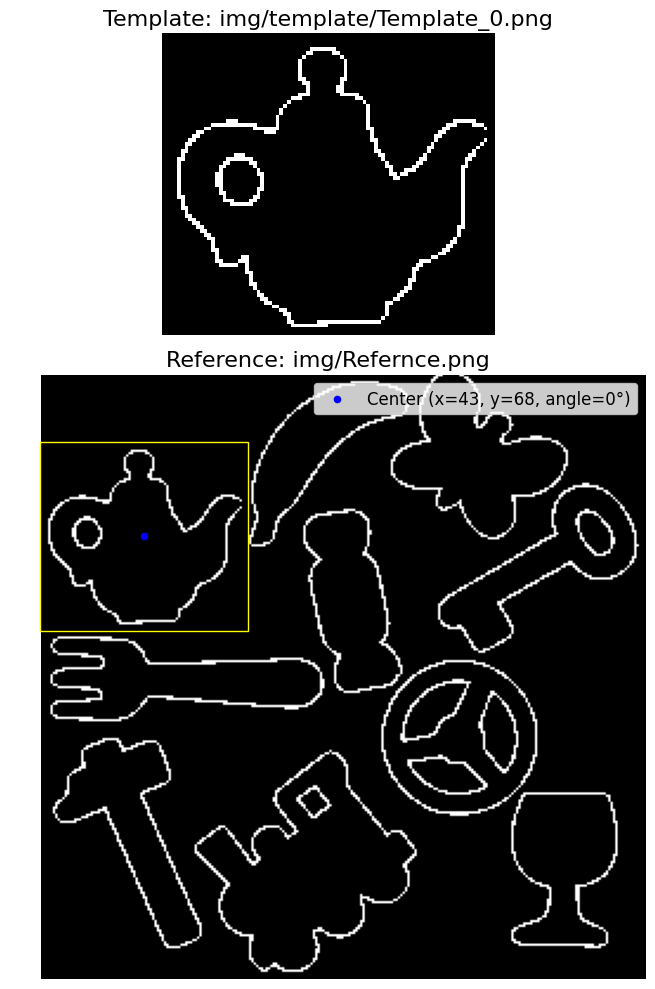

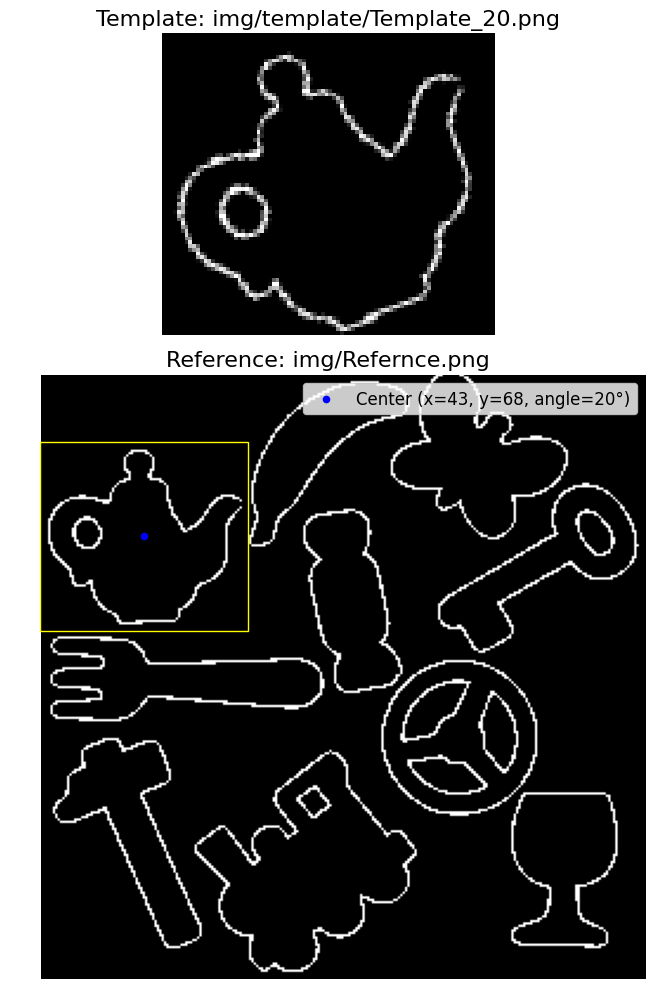

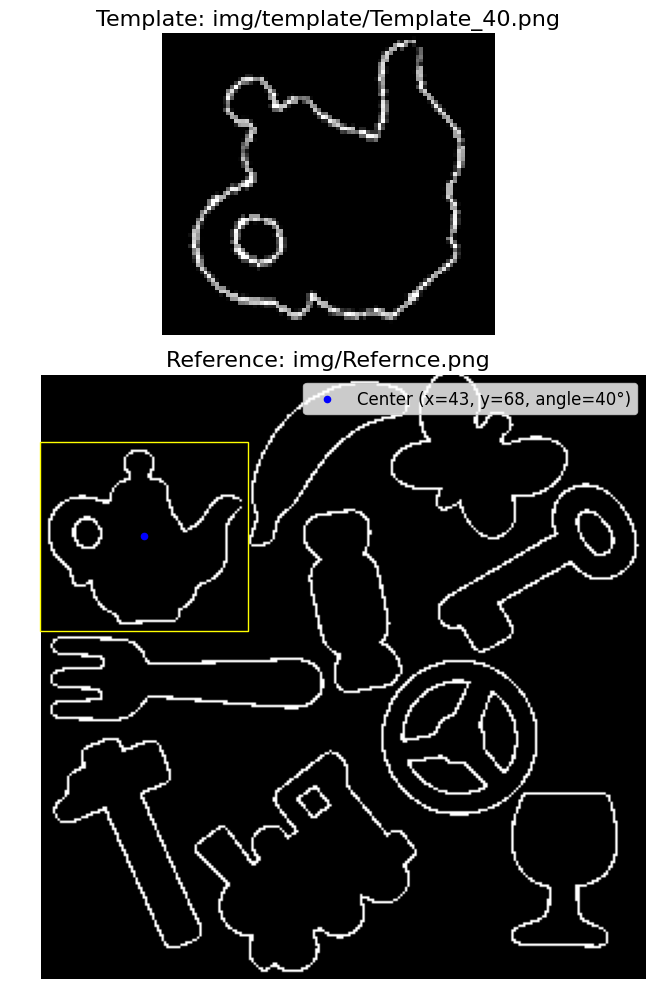

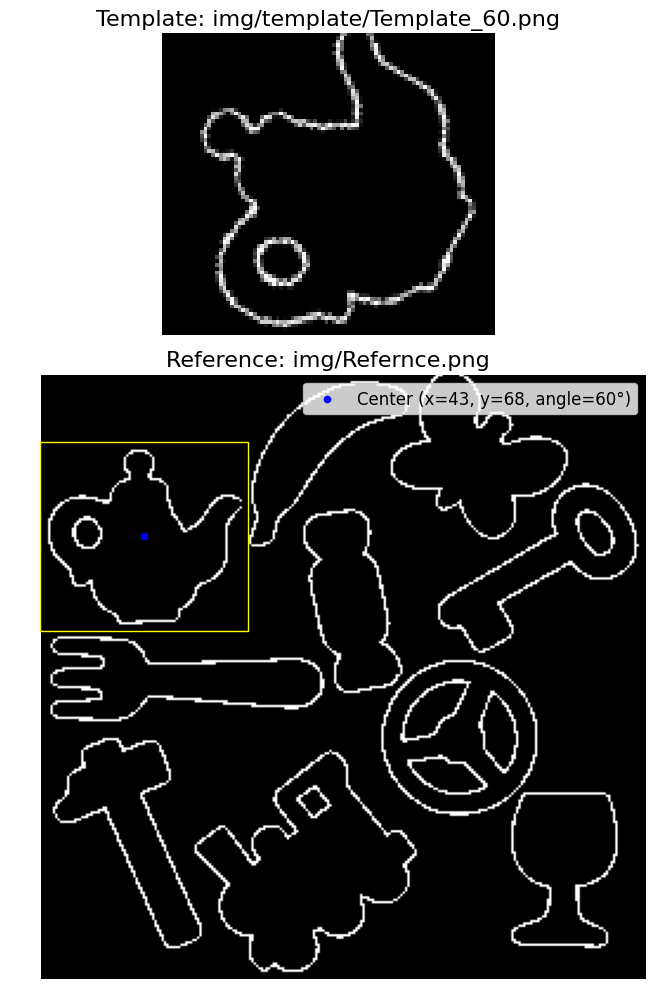

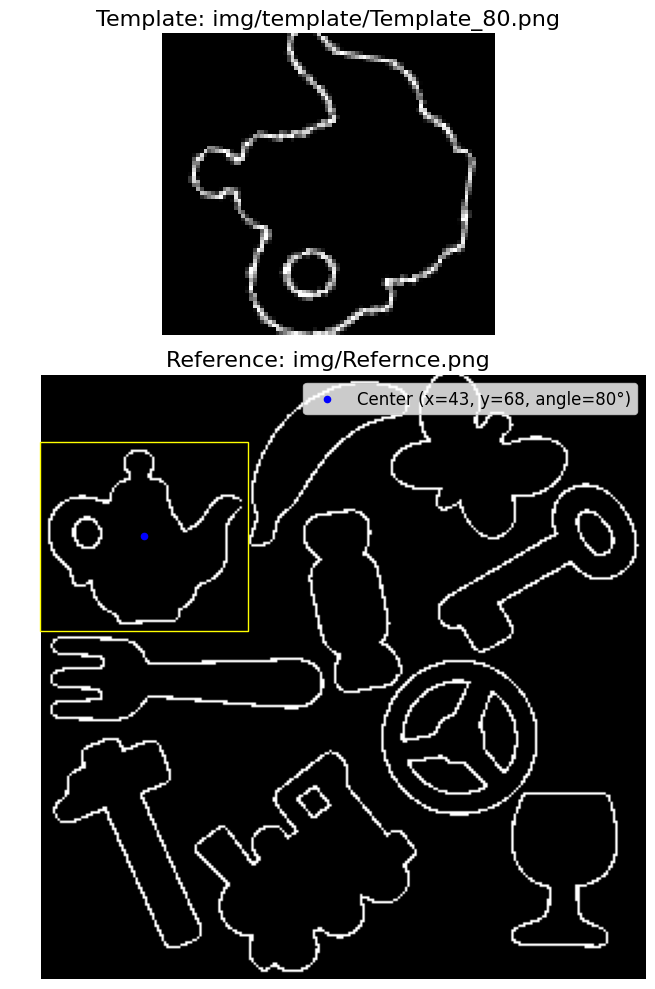

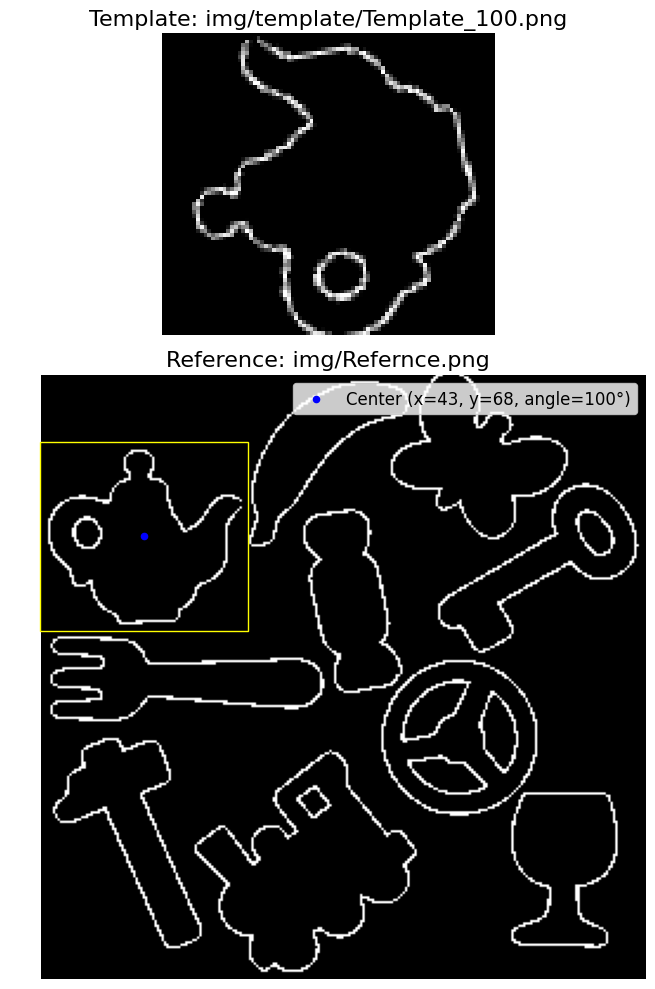

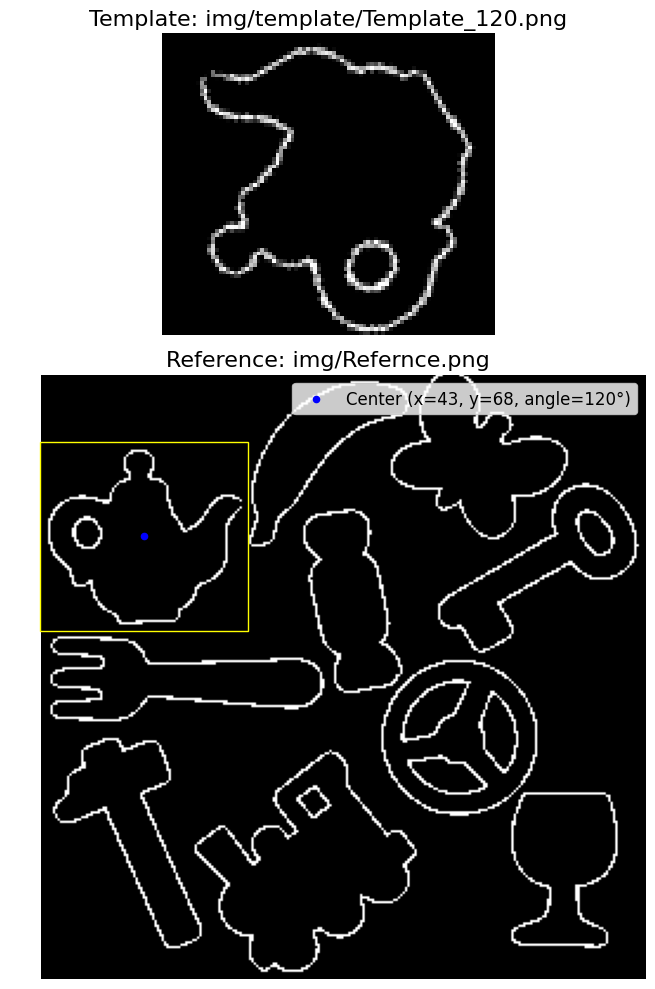

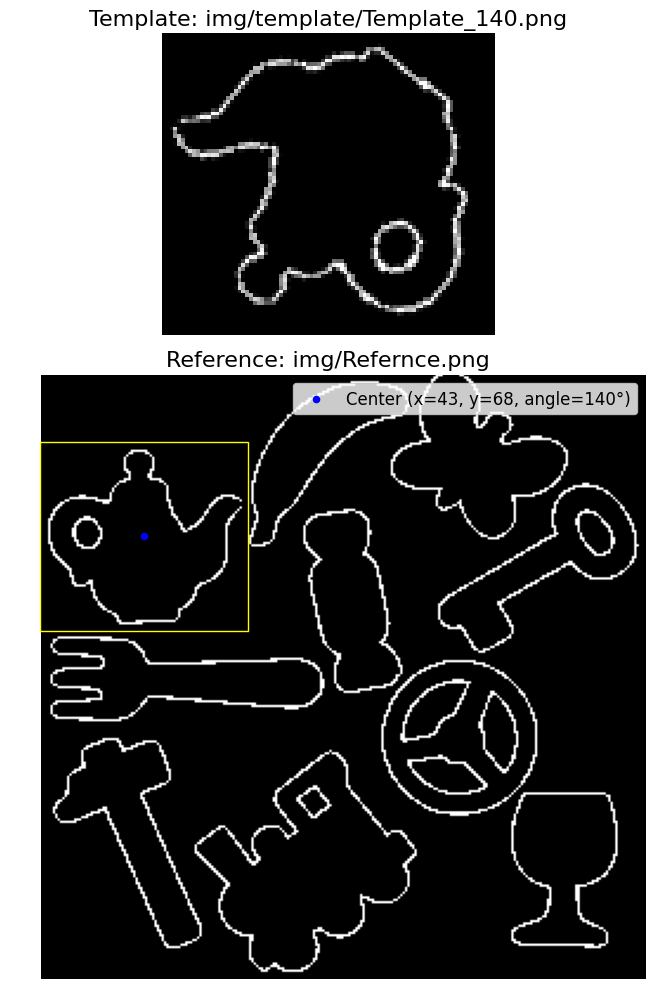

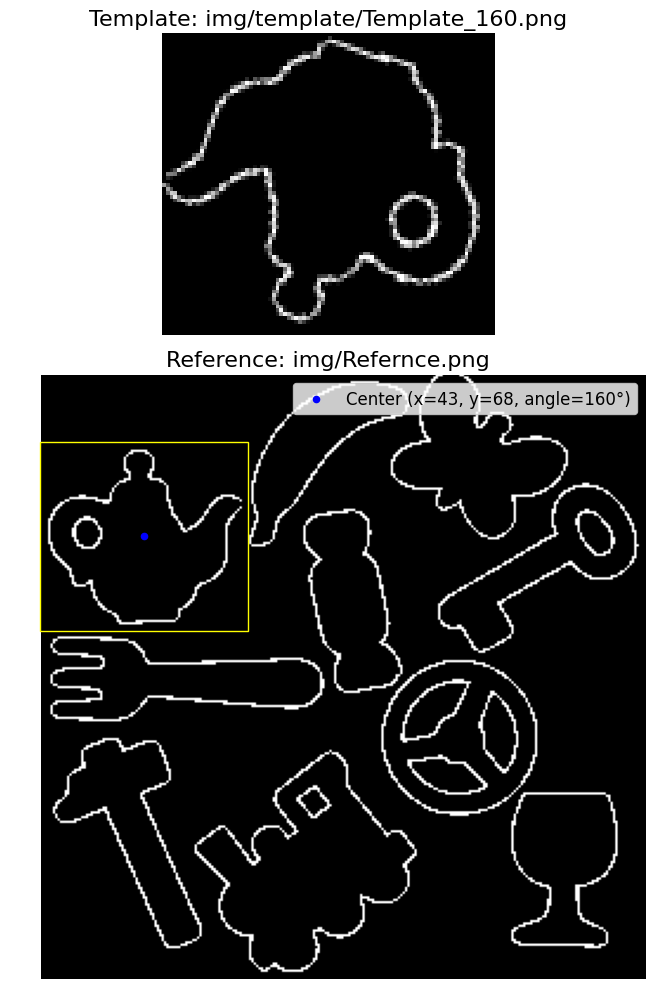

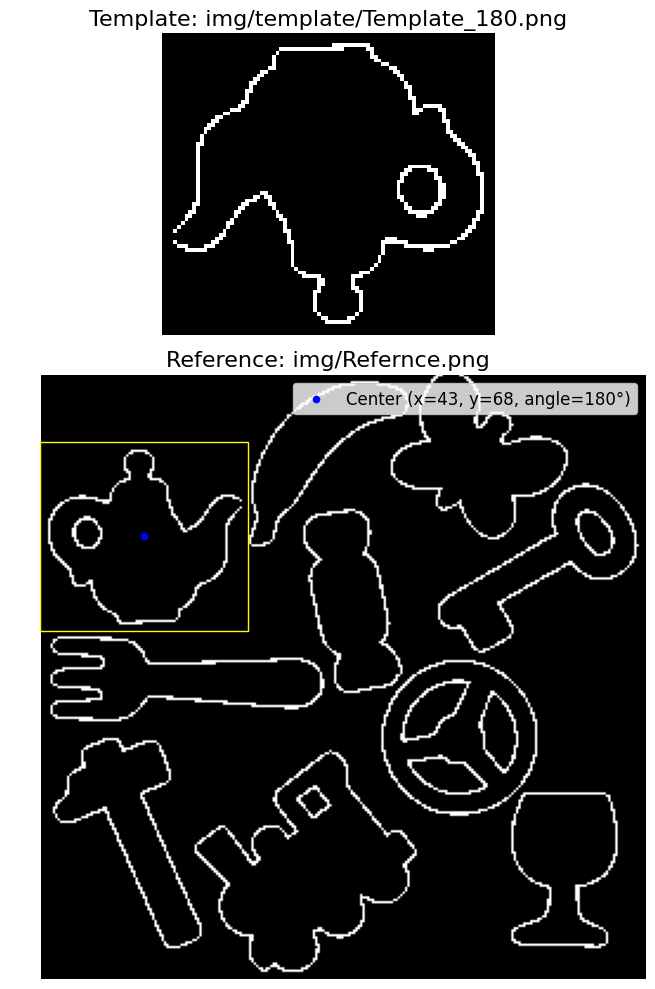

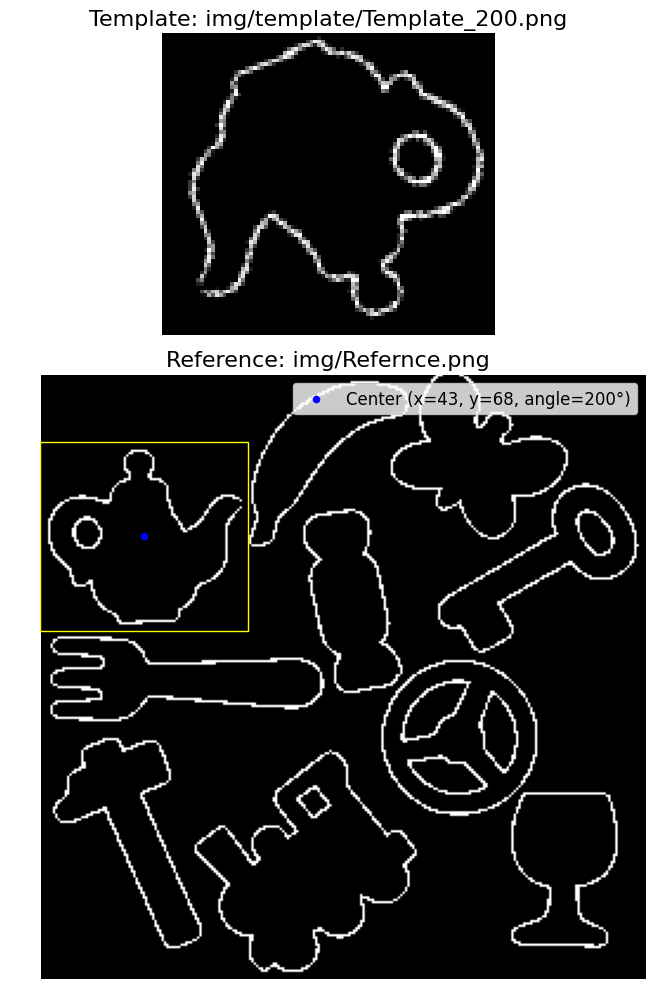

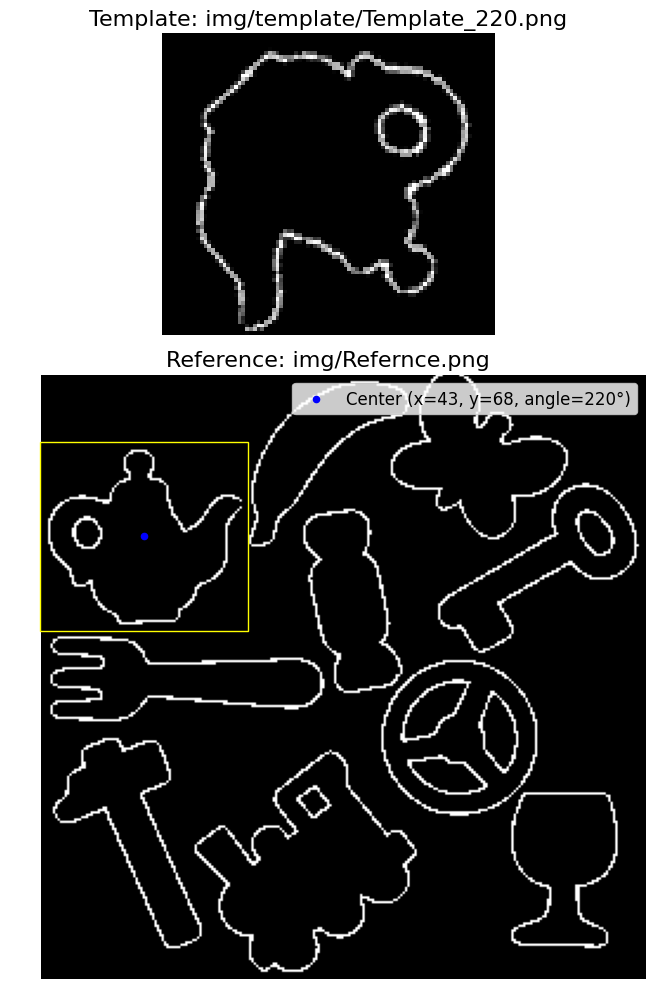

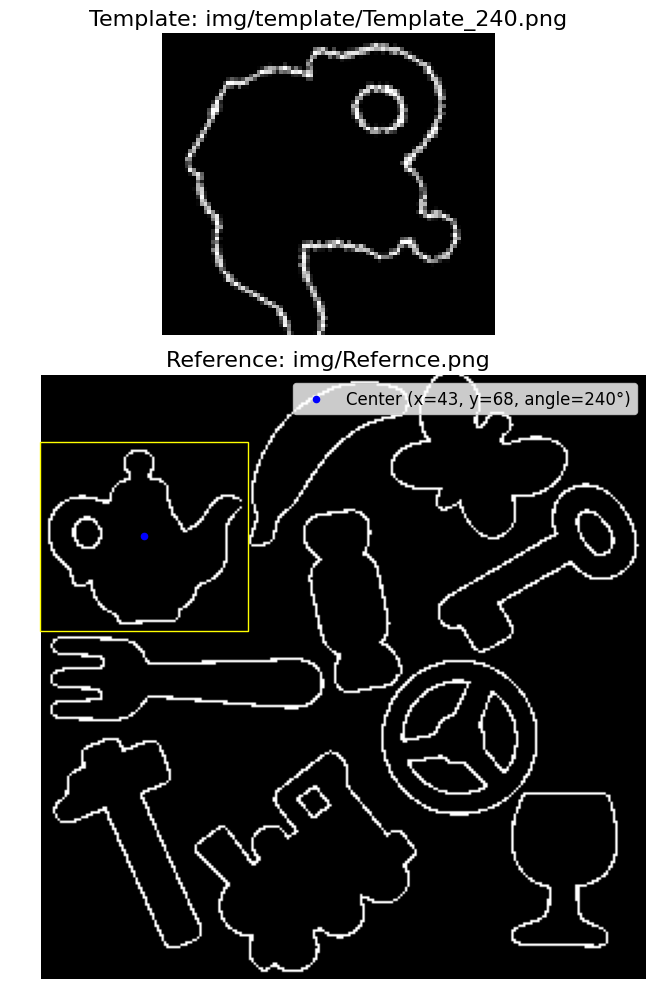

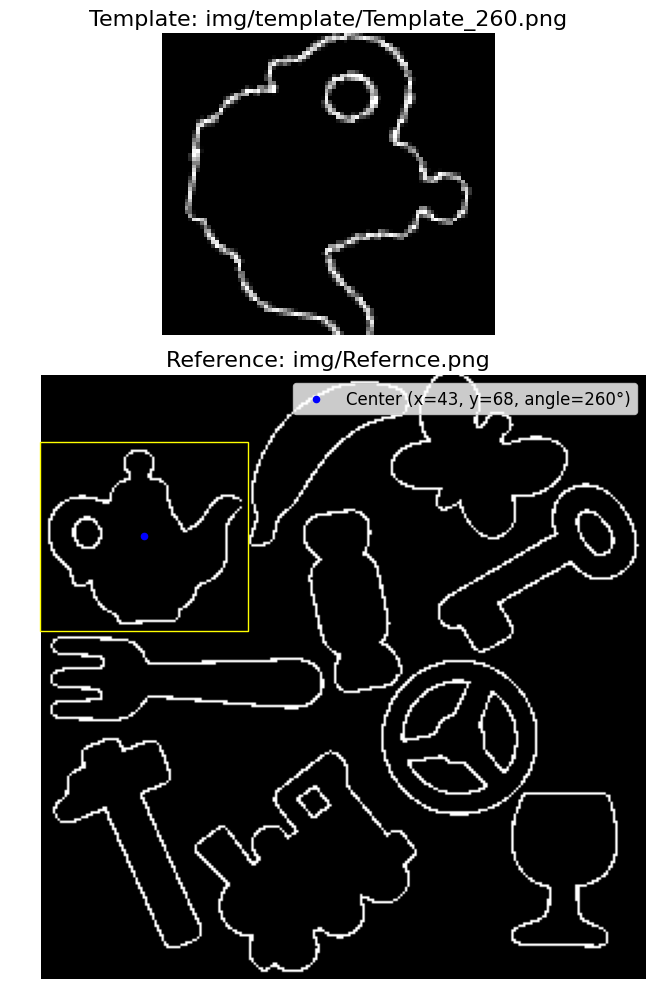

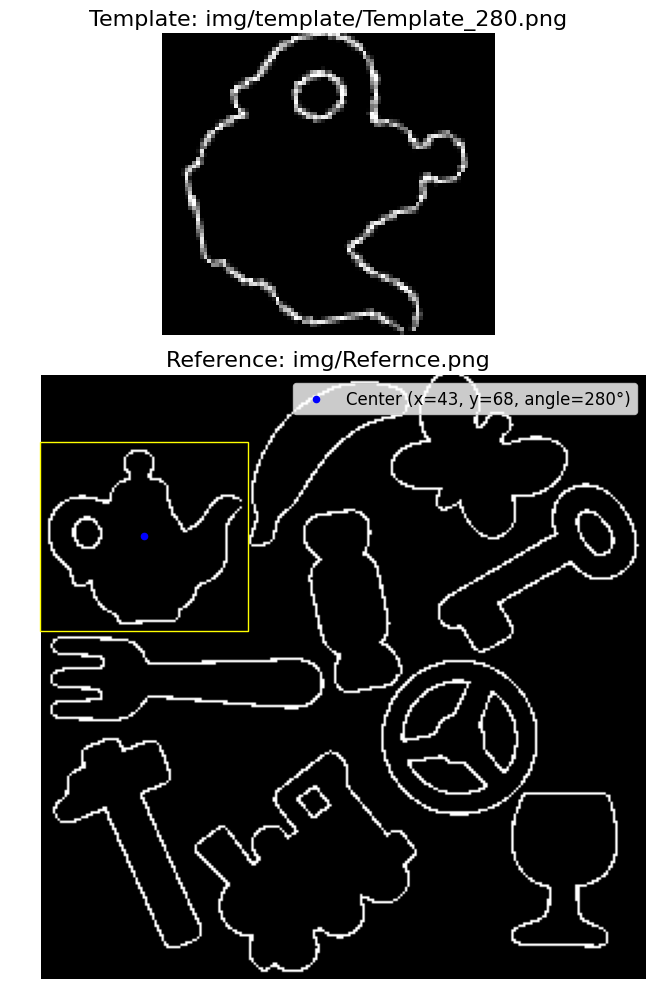

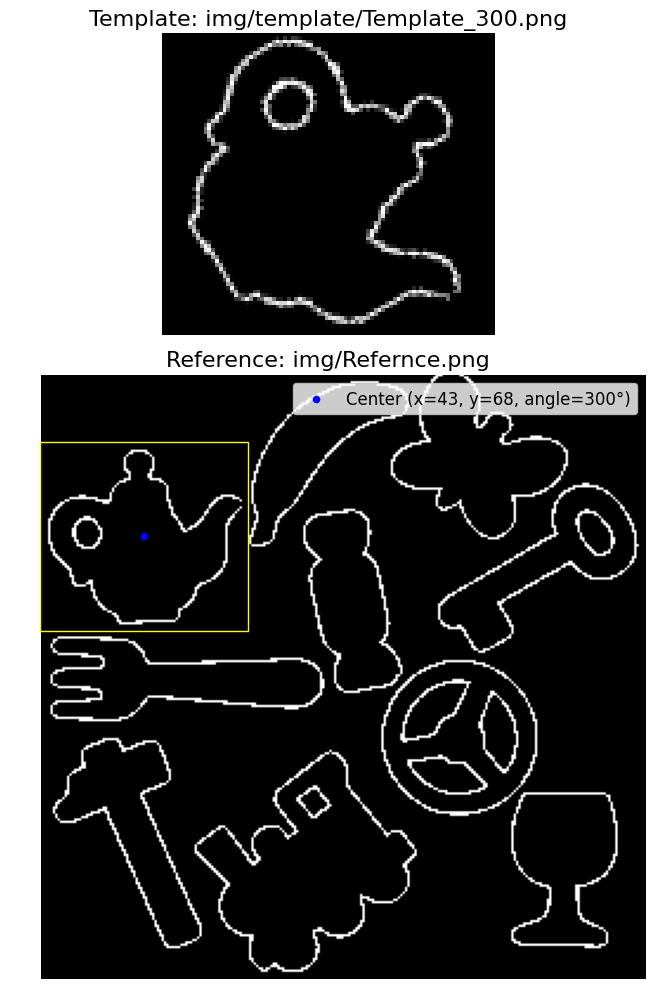

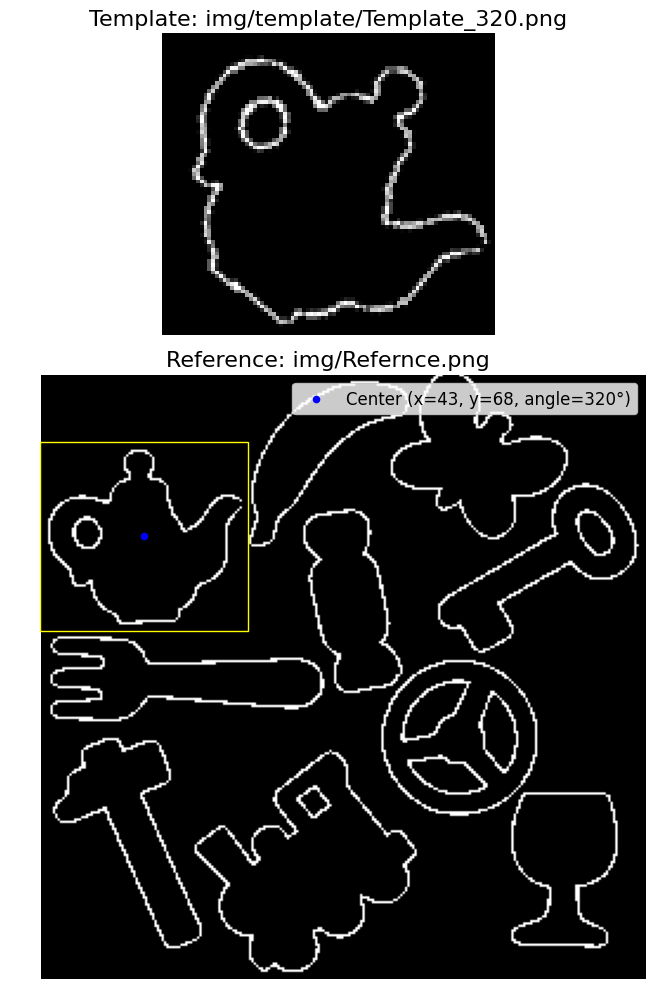

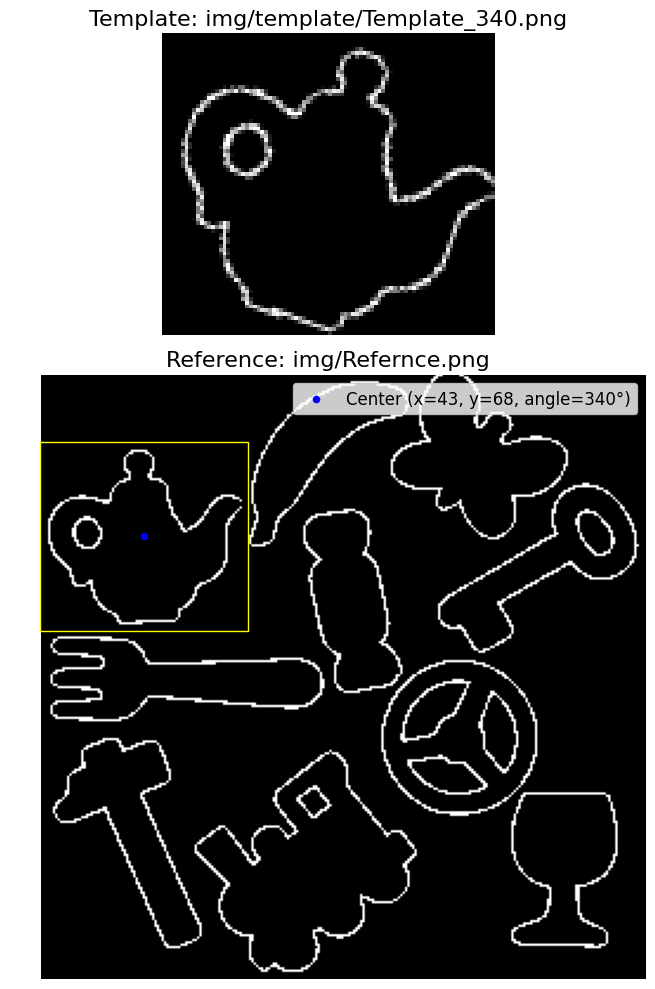

In [7]:
if __name__ == '__main__':
    main()

角度 (度)： [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195

c:\Users\Yuson\Documents\Program\Python\ComputerVision\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Yuson\Documents\Program\Python\ComputerVision\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Yuson\Documents\Program\Python\ComputerVision\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20989 (\N{CJK UNIFIED IDEOGRAPH-51FD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Yuson\Documents\Program\Python\ComputerVision\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25976 (\N{CJK UNIFIED IDEOGRAPH-6578}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Yuson\Documents

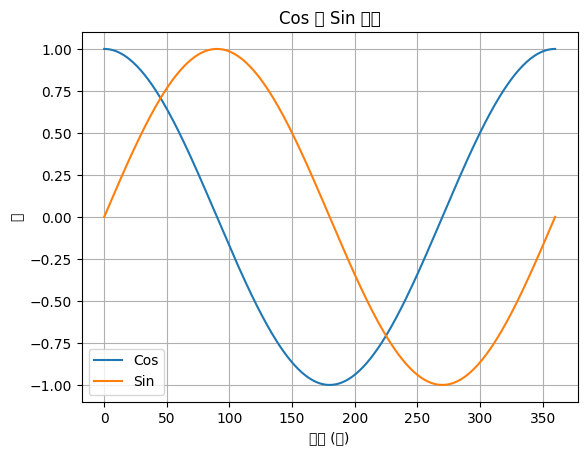

In [6]:
# 生成從 0 到 360 度的角度數組
angles_deg = np.linspace(0, 359, 360)  # 361個點，從0到360度

# 轉換角度到弧度
angles_rad = np.deg2rad(angles_deg)

# 計算cos和sin值
cos_values = np.cos(angles_rad)
sin_values = np.sin(angles_rad)

print("角度 (度)：", angles_deg)
print("Cos值：", cos_values)
print("Sin值：", sin_values)

plt.plot(angles_deg, cos_values, label="Cos")
plt.plot(angles_deg, sin_values, label="Sin")
plt.xlabel("角度 (度)")
plt.ylabel("值")
plt.title("Cos 和 Sin 函數")
plt.legend()
plt.grid(True)
plt.show()